In [91]:
# imports and loading
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import sys
sys.path.insert(0, '../functions/')
import interface_GAMS as iG
import pickle
import os
from matplotlib.colors import Normalize
import ast

# load in a bunch of potentially useful files
# loading merged log_tpm_file
# merge together log_tpm_df files
log_tpm_df = pd.read_csv('../data/precise_1.0/log_tpm.csv', index_col = 0)
starve_log_tpm = pd.read_csv('../data/validation_data_sets/stationary_phase/cleaned_log_tpm_qc.csv', index_col = 0)
to_blank_inds = list(set(log_tpm_df.index) - set(starve_log_tpm.index))
# need to create zero rows for missing values
zeros_data = {col : 0 for col in starve_log_tpm.columns}
zeros_df = pd.DataFrame(zeros_data, index = to_blank_inds)
starve_log_tpm = pd.concat([starve_log_tpm, zeros_df])
starve_log_tpm = starve_log_tpm.loc[log_tpm_df.index]
log_tpm_df = pd.concat([starve_log_tpm, log_tpm_df], axis = 1)

iM_to_genes = {}
k_to_iM = {}
f = open('../data/precise_1.0/iM_table.csv', 'r')
lines = f.readlines()
f.close()
k_to_iM = {line.split(',')[0] : line.split(',')[1] for line in lines[1:]}
f = open('../data/precise_1.0/gene_presence_list.csv', 'r')
lines = f.readlines()
f.close()
for line in lines[1:]:
    k = line.split(',')[1]
    iM = k_to_iM[k]
    gene = line.split(',')[2].replace('\n', '')
    if iM not in iM_to_genes:
        iM_to_genes.update({iM : []})
    iM_to_genes[iM].append(gene)

A = pd.read_csv('../data/precise_1.0/A.csv', index_col = 0).rename(index = {int(k) : v for k, v in k_to_iM.items()})
M = pd.read_csv('../data/precise_1.0/M.csv', index_col = 0).rename(columns = {str(k) : v for k, v in k_to_iM.items()})
centered_log_tpm = log_tpm_df.sub(log_tpm_df[['control__wt_glc__1','control__wt_glc__2']].mean(axis=1),axis=0)
all_A = M.T.dot(centered_log_tpm)

starve_metabs = pd.read_excel('../data/validation_data_sets/stationary_phase/metabolites_data.xlsx', index_col = 0)

pickle_in = open('../data/b_to_gene.pkl', 'rb')
b_to_gene = pickle.load(pickle_in)
pickle_in.close()
gene_to_b = {v : k for k, v in b_to_gene.items()}

In [92]:
# show all possible targets
TF_flags_df = pd.read_csv('../data/TF_flags_expanded.csv', index_col = 0)
keep = set()
for index, row in TF_flags_df.iterrows():
    for effector in ast.literal_eval(row['effectors']):
        if effector in starve_metabs.index:
            keep.add(index)
TF_flags_df.loc[list(keep)].sort_index()

,TF,gene_name,effectors,cAct_no_effector_form,cAct_multi_effector_binding,cAct_multi_co_effector_binding,cInh_no_effector_form,cInh_multi_effector_binding,cInh_multi_co_effector_binding,kd_inh_metab_up,kd_inh_metab_lo,kd_act_metab_up,kd_act_metab_lo
Arginine,argR,b3237,['Arginine'],0.0,1.0,0.0,0.0,1.0,0.0,0.031863,4.029000e-07,0.031863,4.029000e-07
Cra,cra,b0080,"['FructoseN/A1,6N/ABisphosphate']",0.0,1.0,0.0,0.0,1.0,0.0,0.254328,2.831000e-07,0.254328,2.831000e-07
Crp-1,crp,b3357,['AcetylN/ACoA'],0.0,1.0,0.0,0.0,1.0,0.0,0.150544,1.382500e-07,0.150544,1.382500e-07
Crp-2,crp,b3357,['AcetylN/ACoA'],0.0,1.0,0.0,0.0,1.0,0.0,0.150544,1.382500e-07,0.150544,1.382500e-07
Cysteine-1,cysB,b1275,['Serine'],0.0,1.0,0.0,0.0,1.0,0.0,0.124349,1.662050e-06,0.124349,1.662050e-06
Cysteine-2,cysB,b1275,['Serine'],0.0,1.0,0.0,0.0,1.0,0.0,0.124349,1.662050e-06,0.124349,1.662050e-06
Fatty Acid,fadR,b1187,['AcetylN/ACoA'],0.0,1.0,0.0,0.0,1.0,0.0,0.150544,1.382500e-07,0.150544,1.382500e-07
Lrp,lrp,b0889,['Leucine/Isoleucine'],0.0,1.0,0.0,0.0,1.0,0.0,0.193238,1.327000e-06,0.193238,1.327000e-06
Lysine/T2SS,argP,b2916,"['Aginine', 'Leucine/Isoleucine']",0.0,0.0,1.0,0.0,0.0,1.0,0.193238,1.327000e-06,0.193238,1.327000e-06
Purine,purR,b1658,"['Guanine', 'Hypoxanthine']",0.0,0.0,1.0,0.0,0.0,1.0,0.048076,4.795000e-08,0.048076,4.795000e-08


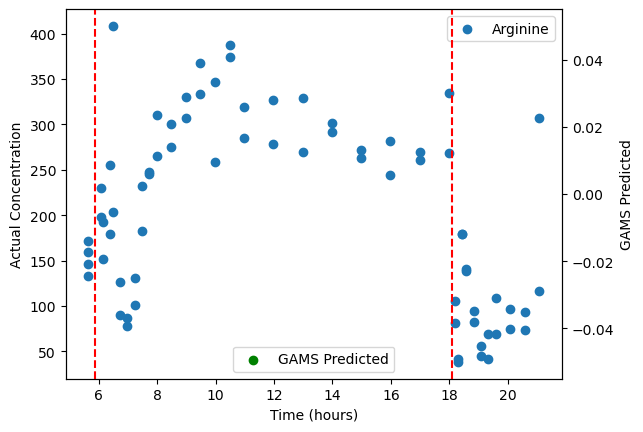

In [93]:
# plotting

# settings
case = 'Arginine'
include_GAMS_predicted = True

if True:
    metabolites = ast.literal_eval(TF_flags_df.loc[case.split('___')[0]]['effectors'])
    if include_GAMS_predicted:
        iter_f = 'iter_'+str(max([int(f.split('_')[1]) for f in os.listdir('../GAMs/optimization_runs/'+case) if 'iter_' in f and '.pkl' not in f]))
        run_f = 'run_'+str(max([int(f.split('_')[1]) for f in os.listdir('../GAMs/optimization_runs/'+case+'/'+iter_f) if 'run_' in f and '.pkl' not in f]))
        GAMs_run_dir = '../GAMs/optimization_runs/'+case+'/'+iter_f+'/'+run_f
        GAMS_calc_cAct, cAct_kd_df, act_metab_df, act_kd_metab_df, GAMS_calc_cInh, cInh_kd_df, inh_metab_df, inh_kd_metab_df = iG.read_multi_GAMs(GAMs_run_dir)
        metab_df = inh_metab_df[inh_metab_df['iM'] == case]

    times = 't0_1	t1_1	t2_1	t3_1	t4_1	t5_1	t6_1	t7_1	t8_1	t9_1	t10_1	t11_1	t12_1	t13_1	t14_1	t15_1	t16_1	t17_1	t18_1	t19_1	t20_1	t21_1	t22_1	t23_1	t24_1	t25_1	t26_1	t27_1	t28_1	t29_1	t30_1	t31_1	t32_1	t33_1	t34_1'
    hours = '5.65	6.07	6.15	6.38	6.48	6.73	6.98	7.23	7.48	7.73	7.98	8.48	8.98	9.48	9.98	10.48	10.98	11.98	12.98	13.98	14.98	15.98	16.98	17.98	18.18	18.28	18.42	18.58	18.83	19.08	19.33	19.58	20.08	20.58	21.08'
    time_to_hours = {k.split('_')[0] : float(v) for k, v in zip(times.split('\t'), hours.split('\t'))}

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    for metabolite in metabolites:
        x_vals = []
        y_vals = []
        time_to_vals = {}
        for sample, val in starve_metabs.loc[metabolite][1:].items():
            tim = 't'+str(int(sample.split('__t')[1].split('_')[0]))
            x_vals.append(time_to_hours[tim])
            y_vals.append(val)
            if time_to_hours[tim] not in time_to_vals:
                time_to_vals.update({time_to_hours[tim] : []})
            time_to_vals[time_to_hours[tim]].append(val)
        ax1.scatter(x_vals, y_vals, label = metabolite)
    if include_GAMS_predicted:
        x_vals = []
        y_vals = []
        for sample, _ in starve_metabs.loc[metabolite][1:].items():
            if sample in metab_df.index:
                tim = 't'+str(int(sample.split('__t')[1].split('_')[0]))
                x_vals.append(time_to_hours[tim])
                y_vals.append(metab_df.loc[sample].Val)
        ax2.scatter(x_vals, y_vals, label = 'GAMS Predicted', c = 'green')
    ax1.legend()
    ax2.legend()
    ax1.set_ylabel('Actual Concentration')
    ax2.set_ylabel('GAMS Predicted')
    ax1.set_xlabel('Time (hours)')
    plt.axvline(x = np.mean([5.65, 6.07]), c = 'r', ls = '--')
    plt.axvline(x = np.mean([17.98, 18.18]), c = 'r', ls = '--')
    plt.savefig('../figures/metabolite_conc.pdf', transparent = True)
    plt.show()

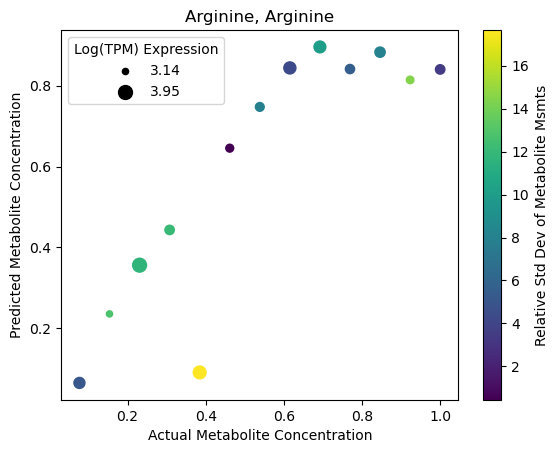

In [94]:
# let's also do the resulting metabolite concentration plots
# conversion to metabolite total concentration

# settings
color_by = 'rsd' # time, rsd
min_size = 20
max_size = 100
cols_use = 'starved' # starved, fed, all (all)
compare_percentiles_or_actual = '%ile' # %ile, actual
multi_metabolites_mean_or_index = 'mean' # mean, 0, 1
interactive = False

if True:
    #metabolites = ['Arginine']#['Guanine', 'Hypoxanthine']

    if True: # setup/loading for run
        fed = ['starve_series__t00_growth1',
            'starve_series__t01_starve',
            'starve_series__t22_growth2',
            'starve_series__t23_growth2',
            'starve_series__t27_growth2',
            'starve_series__t28_growth2',]
        starved = ['starve_series__t02_starve',
         'starve_series__t03_starve',
         'starve_series__t06_starve',
         'starve_series__t07_starve',
         'starve_series__t08_starve',
         'starve_series__t09_starve',
         'starve_series__t10_starve',
         'starve_series__t11_starve',
         'starve_series__t12_starve',
         'starve_series__t14_starve',
         'starve_series__t16_starve',
         'starve_series__t17_starve',
         'starve_series__t18_starve',]

        if cols_use == 'all':
            cols_use = fed+starved
        elif cols_use == 'fed':
            cols_use = fed
        elif cols_use == 'starved':
            cols_use = starved

        times = 't0_1	t1_1	t2_1	t3_1	t4_1	t5_1	t6_1	t7_1	t8_1	t9_1	t10_1	t11_1	t12_1	t13_1	t14_1	t15_1	t16_1	t17_1	t18_1	t19_1	t20_1	t21_1	t22_1	t23_1	t24_1	t25_1	t26_1	t27_1	t28_1	t29_1	t30_1	t31_1	t32_1	t33_1	t34_1'
        hours = '5.65	6.07	6.15	6.38	6.48	6.73	6.98	7.23	7.48	7.73	7.98	8.48	8.98	9.48	9.98	10.48	10.98	11.98	12.98	13.98	14.98	15.98	16.98	17.98	18.18	18.28	18.42	18.58	18.83	19.08	19.33	19.58	20.08	20.58	21.08'
        time_to_hours = {k.split('_')[0] : float(v) for k, v in zip(times.split('\t'), hours.split('\t'))}

        # load in relevant data
        starve_metabs = pd.read_csv('../data/validation_data_sets/stationary_phase/cleaned_metabolites_data.csv', index_col = 0)
        # above is in (µM) , convert to M
        starve_metabs[starve_metabs.columns[1:]] *= 1e-6
        starve_log_tpm = pd.read_csv('../data/validation_data_sets/stationary_phase/cleaned_log_tpm_qc.csv', index_col = 0)
        #starve_cols = list(set(starve_log_tpm.columns).intersection(actual_df.columns))

        iter_f = 'iter_'+str(max([int(f.split('_')[1]) for f in os.listdir('../GAMs/optimization_runs/'+case) if 'iter_' in f and '.pkl' not in f]))
        run_f = 'run_'+str(max([int(f.split('_')[1]) for f in os.listdir('../GAMs/optimization_runs/'+case+'/'+iter_f) if 'run_' in f and '.pkl' not in f]))
        GAMs_run_dir = '../GAMs/optimization_runs/'+case+'/'+iter_f+'/'+run_f
        GAMS_calc_cAct, cAct_kd_df, act_metab_df, act_kd_metab_df, GAMS_calc_cInh, cInh_kd_df, inh_metab_df, inh_kd_metab_df = iG.read_multi_GAMs(GAMs_run_dir)
        metab_df = inh_metab_df[inh_metab_df['iM'] == case]

        cAct_mapping = pd.read_csv(GAMs_run_dir+'/input_files/cAct_mapping.csv', index_col = 0)
        cInh_mapping = pd.read_csv(GAMs_run_dir+'/input_files/cInh_mapping.csv', index_col = 0)

    if compare_percentiles_or_actual == 'actual':
        metabs_df = starve_metabs[cols_use]
    else:
        metabs_df = starve_metabs[cols_use].rank(axis = 1) / len(cols_use)

    # plotting
    iM = case
    # grab genes
    g1 = cAct_mapping[cAct_mapping[iM] != 0].index.to_list()
    g2 = cInh_mapping[cInh_mapping[iM] != 0].index.to_list()
    genes = list(set(g1).union(g2))

    gene = genes[0]

    # settings

    # a little gimmicky now, should be not just hard set to inhibitor but both examples are right now inhibitors
    pred_metab_df = inh_metab_df[inh_metab_df['iM'] == iM]
    if compare_percentiles_or_actual != 'actual':
        pred_metab_df['Val'] = pred_metab_df['Val'].rank() / len(pred_metab_df.index)

    rsd_df = pd.read_csv('../data/validation_data_sets/stationary_phase/rsd_df.csv', index_col = 0)
    def map_value_to_color(value, vmin, vmax, colormap_name):
        # Normalize the value to be between 0 and 1
        normalized_value = (value - vmin) / (vmax - vmin)

        # Ensure the normalized value is within the [0, 1] range
        normalized_value = np.clip(normalized_value, 0, 1)

        # Get the colormap
        colormap = plt.get_cmap(colormap_name)

        # Map the normalized value to a color from the colormap
        color = colormap(normalized_value)

        # Convert the RGBA color to a hex representation
        hex_color = "#{:02x}{:02x}{:02x}".format(int(color[0] * 255), int(color[1] * 255), int(color[2] * 255))

        return hex_color
    if color_by == 'time':
        min_t = min(time_to_hours.values())
        max_t = max(time_to_hours.values())
    elif color_by == 'rsd':
        min_t = min(rsd_df[cols_use].loc[metabolites].sum())
        max_t = max(rsd_df[cols_use].loc[metabolites].sum())

    min_exp = min(starve_log_tpm.loc[gene][cols_use])
    max_exp = max(starve_log_tpm.loc[gene][cols_use])



    fig, ax = plt.subplots()
    labels = []
    colors = []
    sizes = []
    for col in cols_use:
        size_pct = (starve_log_tpm.loc[gene][col] - min_exp) / (max_exp - min_exp)
        size = size_pct * (max_size - min_size) + min_size
        if color_by == 'time':
            val = time_to_hours['t'+str(int(col.split('__t')[1].split('_')[0]))]
        elif color_by == 'rsd':
            val = rsd_df[col].loc[metabolite]
        color = map_value_to_color(val, min_t, max_t, 'viridis')
        colors.append(color)
        sizes.append(size)
        labels.append(col)
    if multi_metabolites_mean_or_index == 'mean':
        scatter = ax.scatter(metabs_df.loc[metabolites][cols_use].mean(), pred_metab_df.loc[cols_use]['Val'], s = sizes, c = colors)
    else:
        scatter = ax.scatter(metabs_df.loc[metabolites[multi_metabolites_mean_or_index]][cols_use], pred_metab_df.loc[cols_use]['Val'], s = sizes, c = colors)
    ax.set_ylabel('Predicted Metabolite Concentration')
    ax.set_xlabel('Actual Metabolite Concentration')

    # Create a ScalarMappable object for the color mapping
    norm = Normalize(vmin=min_t, vmax=max_t)
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])  # Fake a normalization array

    # Add colorbar
    if color_by == 'time':
        cbar = plt.colorbar(sm, ax = ax, label='Time (hours)')
    else:
        cbar = plt.colorbar(sm, ax = ax, label='Relative Std Dev of Metabolite Msmts')

    # Create custom legend
    legend_labels = ['{:.2f}'.format(min_exp), '{:.2f}'.format(max_exp)]
    legend_markers = [plt.scatter([], [], c = 'k', s=min_size),
                      plt.scatter([], [], c = 'k', s=max_size)]
    plt.legend(legend_markers, legend_labels, title='Log(TPM) Expression', loc='upper left')


    # make it pretty
    if len(metabolites) == 1:
        plt.title(iM+', '+metabolites[0])
    else:
        if multi_metabolites_mean_or_index == 'mean':
            plt.title(iM+', mean of '+str(metabolites))
        else:
            plt.title(iM+', '+str(metabolites[multi_metabolites_mean_or_index]))
    plt.savefig('../figures/metabolite_validation.pdf', transparent = True)
    plt.show()

In [81]:
inh_metab_df.Val.sort_values()

sample
p1k_00577    3.800000e-11
p1k_00559    2.803768e-06
p1k_00558    3.643389e-06
p1k_00522    9.787878e-06
p1k_00036    3.444178e-05
                 ...     
p1k_00849    4.124977e-02
p1k_00833    4.128445e-02
p1k_00823    4.145731e-02
p1k_00840    4.281844e-02
p1k_00841    4.304848e-02
Name: Val, Length: 1078, dtype: float64

In [86]:
inh_metab_df.loc[starved].sort_values(by = 'Val')

,iM,Val
sample,,
starve_series__t06_starve,Arginine,0.000083
starve_series__t03_starve,Arginine,0.000096
starve_series__t07_starve,Arginine,0.000147
starve_series__t02_starve,Arginine,0.000181
starve_series__t08_starve,Arginine,0.000211
starve_series__t17_starve,Arginine,0.008381
starve_series__t10_starve,Arginine,0.008397
starve_series__t09_starve,Arginine,0.008467
starve_series__t11_starve,Arginine,0.008543
